# Stability of sentences

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
SAVE_DATA = True

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

DATA = os.path.join(os.path.abspath(os.path.curdir), '{}.pkl.bz2')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_1


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from analysis.utils import grouper, memoized, mpl_palette

## 2 Stability of sentences

First generate our data

In [4]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    root_length = len(root.content_words)
    order.append({'tree id': tree.id,
                  'root length': root_length})
    for sentence in tree.sentences.kept.all():
        if sentence.parent is None:
            rate = 0.0
            cumrate = 0.0
        else:
            rate = sentence.oc_distance(sentence.parent)
            cumrate = sentence.cum_root_distance('oc')
        length = len(sentence.content_words)
        data.append({'tree id': tree.id,
                     'branch id': sentence.head.id if sentence.parent is not None else np.nan,
                     'parent id': sentence.parent.id if sentence.parent is not None else np.nan,
                     'sentence id': sentence.id,
                     'parent length': (len(sentence.parent.content_tokens)
                                       if sentence.parent is not None else np.nan),
                     'parent token length': (len(sentence.parent.tokens)
                                             if sentence.parent is not None else np.nan),
                     'length': length,
                     'token length': len(sentence.tokens),
                     'root length': root_length,
                     'root token length': len(root.tokens),
                     'length / len(root)': length / root_length,
                     'diff from root': root.oc_distance(sentence, normalized=False) / root_length,
                     'depth': sentence.depth,
                     'rate': rate,
                     'cumrate': cumrate})
data = DataFrame(data)
data_m15 = data[data['root length'] < 15]
root_order = DataFrame(order).sort_values(['root length', 'tree id'])

In [5]:
if SAVE_DATA:
    data.to_pickle(DATA.format('stability'))

### 2.1 Quick look at the interactions between transformation rate, length, depth

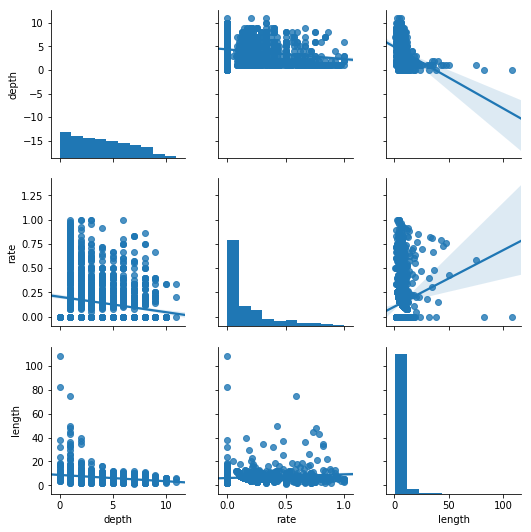

In [6]:
g = sb.pairplot(data=data, vars=['depth', 'rate', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/depth_tr_length_interactions.png', dpi=300)

Now restricting to sentences with less than 15 content words:

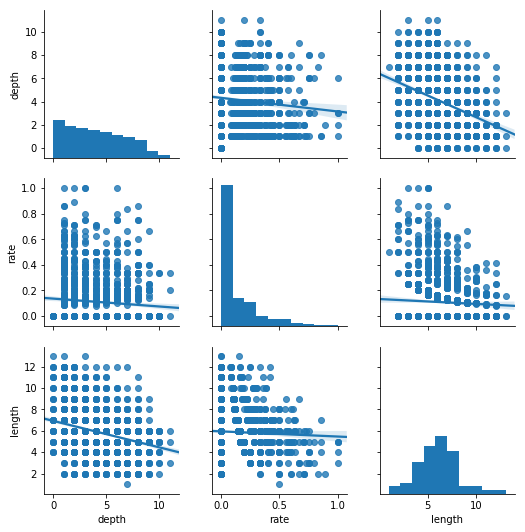

In [7]:
g = sb.pairplot(data=data_m15, vars=['depth', 'rate', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/depth_tr_length_interactions_m15.png', dpi=300)

### 2.2 At fixed sentence length, how does transformation rate depend on depth?

#### 2.2.1 Non-cumulative transformation rate

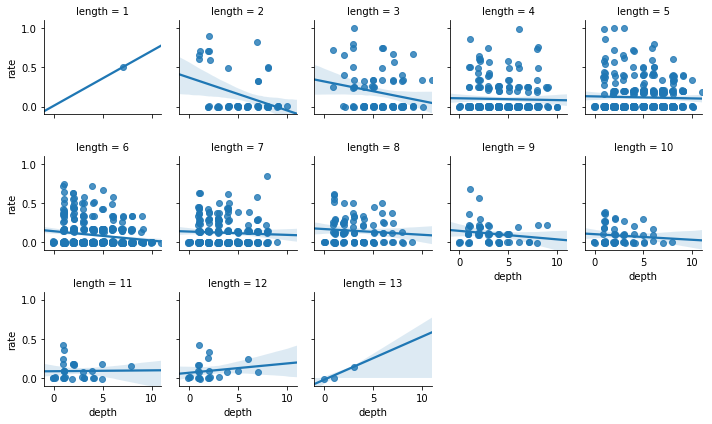

In [8]:
ordered_lengths_m15 = sorted(set(data_m15.length.values))
g = sb.lmplot(data=data_m15, x='depth', y='rate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths_m15,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/tr_depth_fixed-length.png', dpi=300)

#### 2.2.2 Cumulative transformation rate

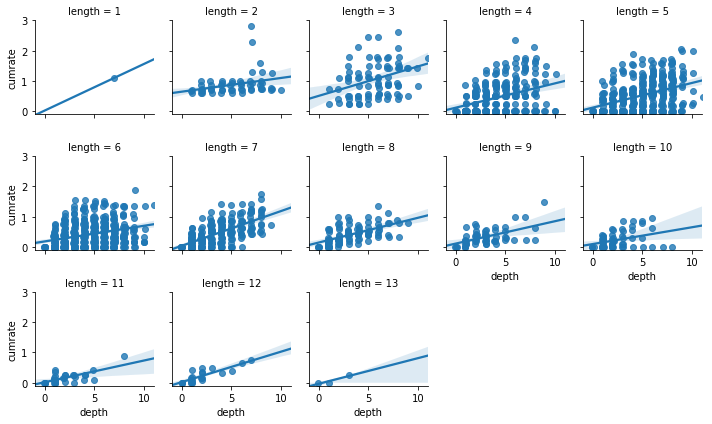

In [9]:
ordered_lengths_m15 = sorted(set(data_m15.length.values))
g = sb.lmplot(data=data_m15, x='depth', y='cumrate',
              col='length', col_wrap=5, size=2, col_order=ordered_lengths_m15,
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 3))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/cumtr_depth_fixed-length.png', dpi=300)

### 2.3 How do trees behave with transformation rate ~ depth?

#### 2.3.1 Non-cumulative transformation rate

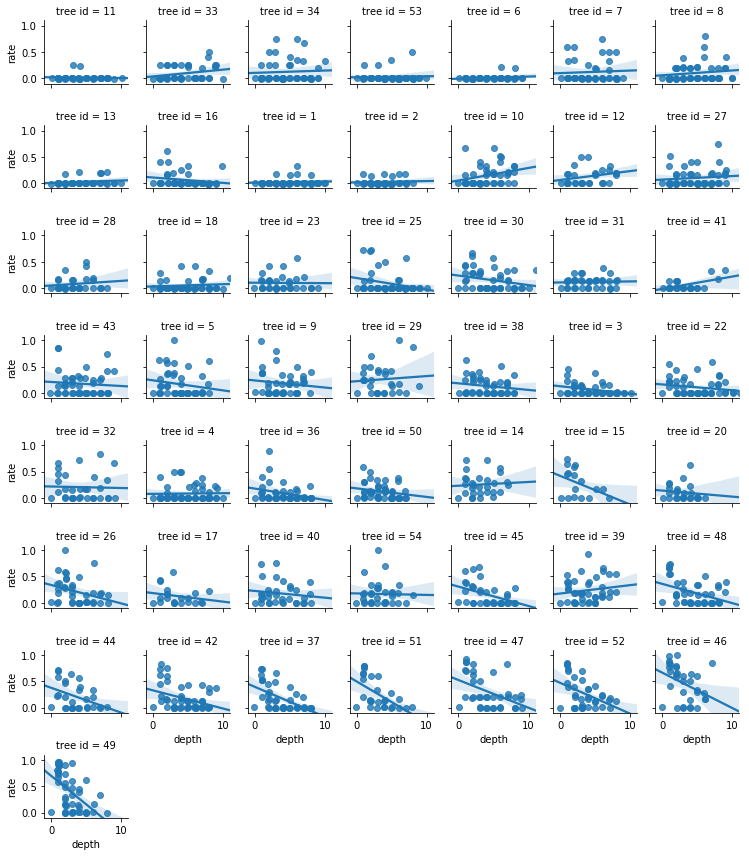

In [10]:
g = sb.lmplot(data=data,
              x='depth', y='rate',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/tr_depth.png', dpi=300)

#### 2.3.2 Cumulative transformation rate

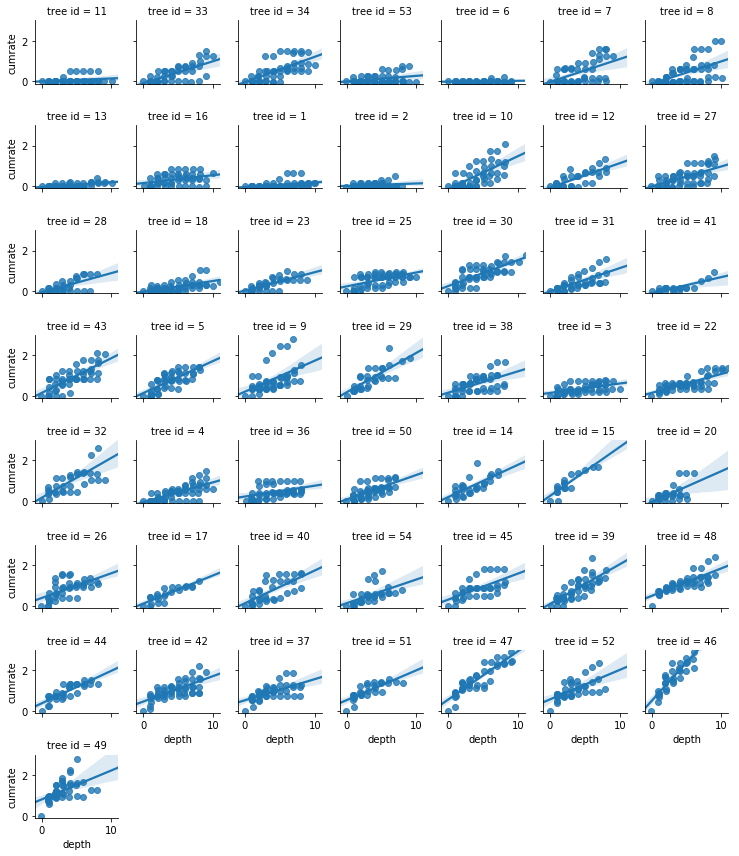

In [11]:
g = sb.lmplot(data=data,
              x='depth', y='cumrate',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 3))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/cumtr_depth.png', dpi=300)

### 2.4 How do trees behave with length ~ depth?

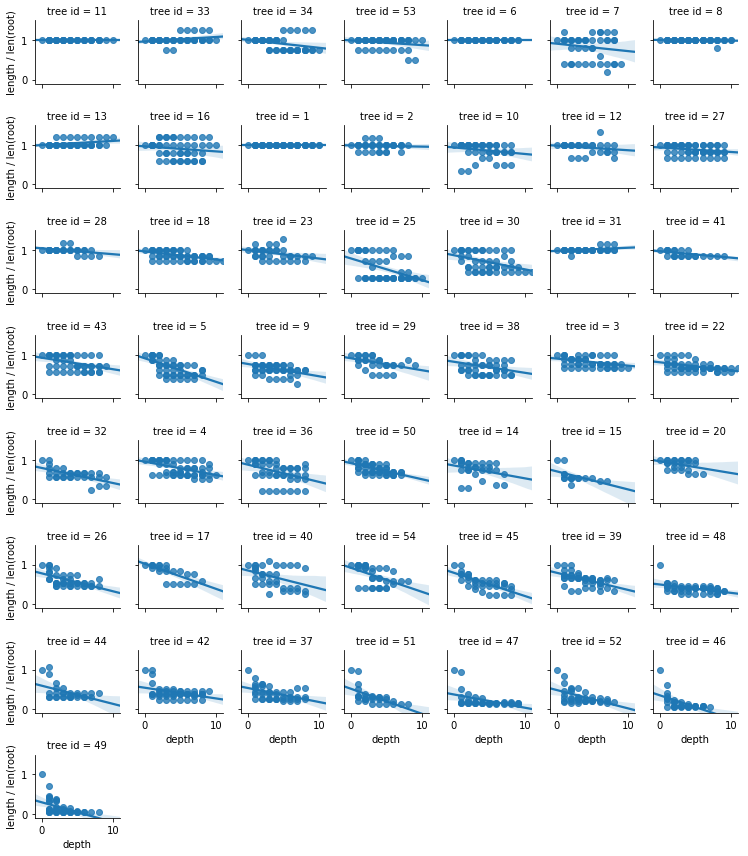

In [12]:
g = sb.lmplot(data=data,
              x='depth', y='length / len(root)',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 11), ylim=(-0.1, 1.5))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/length_depth.png', dpi=300)

In [13]:
print(Tree.objects.get(id=53).root.text)
print(Tree.objects.get(id=53).root.content_words)

He promised he'd be on time for the party tonight
('promised', 'time', 'party', 'tonight')


In [14]:
[s.content_words for s in Tree.objects.get(id=53).sentences.kept.all()]

[('promised', 'time'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time'),
 ('promised', 'time', 'thonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'thonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'night'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'thonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promise', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'night'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'thonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised', 'time', 'tonight'),
 ('promised', 'time', 'party', 'tonight'),
 ('promised

In [15]:
print(Tree.objects.get(id=13).root.text)
print(Tree.objects.get(id=13).root.content_words)

Dinosaurs and humans walked the earth at the same time
('dinosaurs', 'humans', 'walked', 'earth', 'time')


In [16]:
[s.content_words for s in Tree.objects.get(id=13).sentences.kept.all()]

[('dinosaurs', 'humans', 'walked', 'earth', 'exact', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'exact', 'time'),
 ('dinosaurs', 'humans', 'walked', 'world', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'time'),
 ('dinosauras', 'humans', 'walked', 'earth', 'time'),
 ('dinosors', 'humans', 'walked', 'earth', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'exact', 'time'),
 ('dinosaurs', 'humans', 'walked', 'world', 'time'),
 ('dinosaurs', 'humans', 'walked', 'world', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'exact', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'exact', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', 'exact', 'time'),
 ('dinosaurs', 'humans', 'walked', 'earth', '

### 2.5 How do trees behave with difference from root ~ depth?

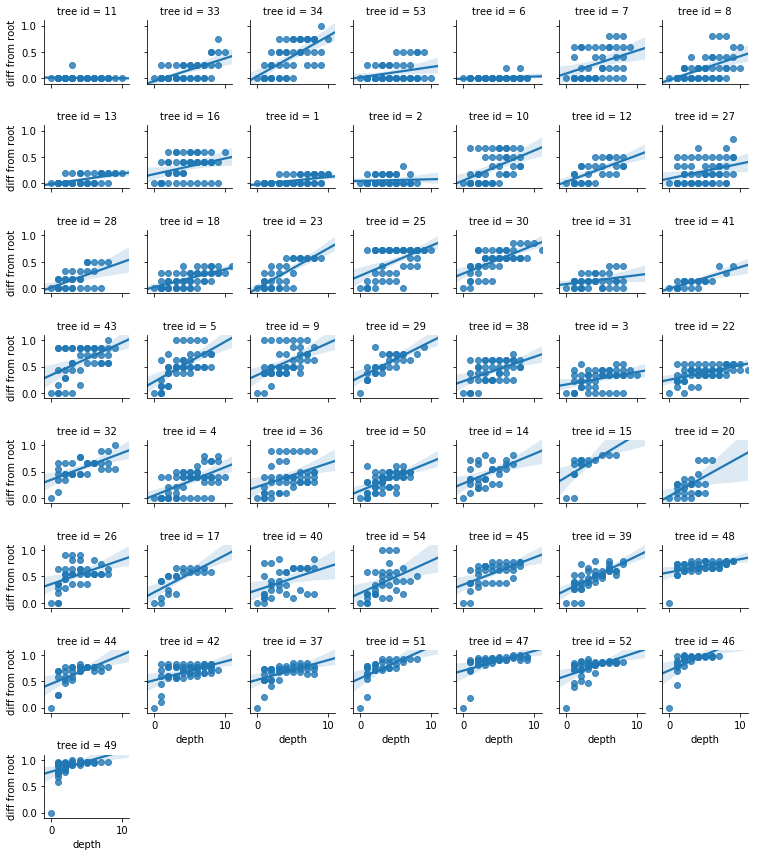

In [17]:
g = sb.lmplot(data=data,
              x='depth', y='diff from root',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig('/home/sl/Downloads/gistr/diffroot_depth.png', dpi=300)